#### Imports and settings

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from random import randint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import markovify as mk

from wordcloud import WordCloud, STOPWORDS
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, GlobalMaxPool1D, LSTM, Dropout, Dense
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import model_from_json
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.initializers import Constant

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import h5py
tf.logging.set_verbosity(tf.logging.ERROR)

%matplotlib inline
%reload_ext jupyternotify

print('Intel-optimized TensorFlow is enabled:', tf.pywrap_tensorflow.IsMklEnabled())

Using TensorFlow backend.


<IPython.core.display.Javascript object>

Intel-optimized TensorFlow is enabled: True


#### Customize IDE (currently raw)

In [2]:
# Font color on plots 
COLOR = 'A9B0C2'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams["figure.figsize"] = [10,5]

#### Load datasets and pretrained models

In [3]:
INPUT_PATH = '../input/'
SUBMISSION_PATH = '../submission/'
MODEL_PATH = '../model/'
PRETRAINED_PATH = '../pretrained-models/'

train = pd.read_csv(f'{INPUT_PATH}train.csv')
test = pd.read_csv(f'{INPUT_PATH}test.csv')
test_labels = pd.read_csv(f'{INPUT_PATH}test_labels.csv')

### EDA (Exploratory data analysis)

In [4]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [5]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
n_train = train.shape[0]
n_test = test.shape[0]
print("Samples in train dataset: ", n_train, "(", round(n_train * 100 / (n_train + n_test)), "% )")
print("Samples in test dataset: ", n_test, "(", round(n_test  *100 / (n_train + n_test)), "% )")

Samples in train dataset:  159571 ( 51 % )
Samples in test dataset:  153164 ( 49 % )


In [8]:
# Do not operate on original test dataset during EDA
train_extended = train.reset_index(drop=True)

In [9]:
comments_labels_train = train_extended.iloc[:,2:]
comments_labels_sums = comments_labels_train.sum(axis=1)
train_extended["clean"] = (comments_labels_sums == 0)
n_clean_samples = train_extended["clean"].sum()
n_toxic_samples = len(train_extended) - n_clean_samples
print("Clean: ", n_clean_samples, "(", round(n_clean_samples * 100 / len(train_extended)), "% )")
print("Toxic: ", n_toxic_samples, "(", round(n_toxic_samples * 100 / len(train_extended)), "% )")

Clean:  143346 ( 90.0 % )
Toxic:  16225 ( 10.0 % )


###### <font color="LIGHTSALMON">The large majority of train dataset are comments labelled as clean</font>

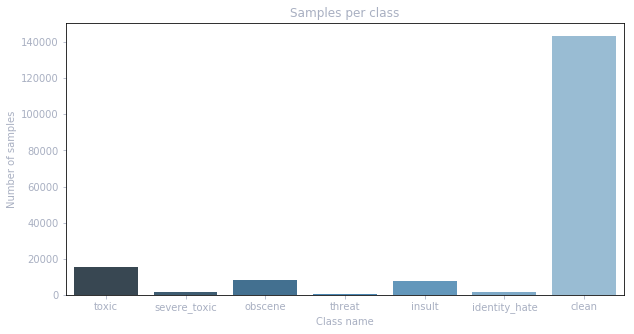

In [10]:
# extended by 'clean' column
summed_labels_extended_train = train_extended.iloc[:,2:].sum()

plt.figure(figsize=(10,5))
plt.title("Samples per class")
plt.ylabel("Number of samples")
plt.xlabel("Class name")
ax = sns.barplot(summed_labels_extended_train.index, summed_labels_extended_train.values, palette="Blues_d")
plt.show()

In [11]:
imbalance_ratios_class_names = {}
imbalance_ratios_class_nums = {}
for label in range(len(summed_labels_extended_train) - 1):
    ratio_label = n_clean_samples / summed_labels_extended_train.get(label)
    imbalance_ratios_class_nums[label] = round(ratio_label, 2)
    imbalance_ratios_class_names[summed_labels_extended_train.index[label]] = round(ratio_label, 2)

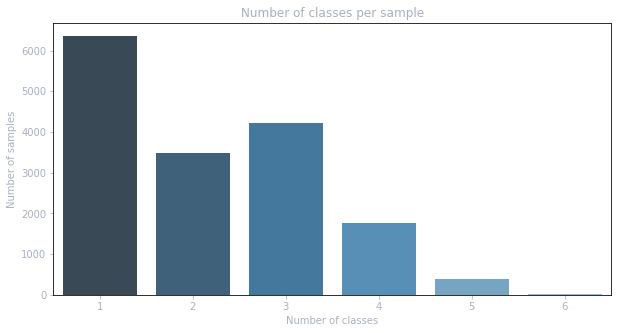

1    6360
3    4209
2    3480
4    1760
5     385
6      31
dtype: int64


In [12]:
# without '0 classes' (clean comments)
multiple_classes_occurance = comments_labels_sums.value_counts().iloc[1:]

plt.figure(figsize=(10,5))
plt.title("Number of classes per sample")
plt.ylabel("Number of samples")
plt.xlabel("Number of classes")
ax = sns.barplot(multiple_classes_occurance.index, multiple_classes_occurance.values, palette="Blues_d")
plt.show()
print(multiple_classes_occurance)

In [13]:
print("Single-classed toxic comments:", '{0:.2f}'.format(multiple_classes_occurance.get(1) / n_toxic_samples * 100), '%')
print("Multiple-classed toxic comments:", '{0:.2f}'.format(multiple_classes_occurance[1:].sum() / n_toxic_samples * 100), '%')

Single-classed toxic comments: 39.20 %
Multiple-classed toxic comments: 60.80 %


###### <font color="LIGHTSALMON">Most of toxic comments has more than one toxic class</font>

#### Example samples

In [14]:
def get_random_sample(comments_group):
    min_samples_in_class = comments_labels_train.sum().min() - 1
    return comments_group.iloc[randint(0, min_samples_in_class), 1]

In [15]:
toxic_samples = train_extended[train_extended.toxic == 1]
severe_toxic_samples = train_extended[train_extended.severe_toxic == 1]
obscene_samples = train_extended[train_extended.obscene == 1]
threat_samples = train_extended[train_extended.threat == 1]
insult_samples = train_extended[train_extended.insult == 1]
identity_hate_samples = train_extended[train_extended.identity_hate == 1]
clean_samples = train_extended[train_extended.clean == 1]

print("Toxic:\n\n>", get_random_sample(toxic_samples))
print("\n --- \n\nSevere toxic:\n\n>", get_random_sample(severe_toxic_samples))
print("\n --- \n\nObscene:\n\n>", get_random_sample(obscene_samples))
print("\n --- \n\nThreat:\n\n>", get_random_sample(threat_samples))
print("\n --- \n\nInsult:\n\n>", get_random_sample(insult_samples))
print("\n --- \n\nIdentity hate:\n\n>", get_random_sample(identity_hate_samples))
print("\n --- \n\nClean:\n\n>", get_random_sample(clean_samples))

Toxic:

> UNBELIEVABLE you went ahead and removed the section unilaterally without waiting from comments from other editors. I'm warning you Wee, abstain from any more disruptive and borderline vandalism editing.

 --- 

Severe toxic:

> PABLO FLORES IS A PIECE OF HUMAN DOGSHIT AND A FUCKING BASTARD

 --- 

Obscene:

> Go Fuck Yourself 

Deeside College is a mother fucking spunk dunk pottery which is held at User:GaryColemanFan .com
and likes to suck Georg Hackenschmidt of and doesn't accept facebook Groups like the official Facebook Professional Wrestling Hall Of Fame (  )

 --- 

Threat:

> Dick 

Hey, dick.

Why don't you go read the Aqua Teen Hunger Force wiki page for Marines episode and see where it actually says jigsaw. I say that would constitue in other media references, wouldn't you?

Probably not, because it seems all of you wiki monitors are fucking cock sucking assholes who don't understand what the fuck is going on half the time.

Seriously, you're a dick. Did you even re

#### Wordclouds

#### Spam significance 

In [16]:
train_extended['n_unique_words'] = train_extended["comment_text"].apply(lambda x: len(set(str(x).split())))
train_extended['n_words'] = train_extended["comment_text"].apply(lambda x: len(str(x).split()))
train_extended['unique_words_per'] = train_extended['n_unique_words'] * 100 / train_extended['n_words']

###### <font color="LIGHTSALMON">Spam ratio (coefficient) =  unique words in comment / number of words in comment</font>

In [17]:
spam_ratio = 10
spammers = train_extended[train_extended['unique_words_per'] < spam_ratio]
clean_spammers = spammers[spammers['clean'] == True]
toxic_spammers = spammers[spammers['clean'] == False]
n_clean_spammers = clean_spammers.shape[0]
n_toxic_spammers = toxic_spammers.shape[0]
n_spammers = spammers.shape[0]
print('For spam coefficient equal 10%:\n')
print('Clean spammers: ', n_clean_spammers, "(", round(n_clean_spammers * 100 / n_spammers), "% )")
print('Toxic spammers: ', n_toxic_spammers, "(", round(n_toxic_spammers * 100 / n_spammers), "% )")
print('\nThere are', '{0:.2f}'.format(n_toxic_spammers / n_clean_spammers), 
      'times more toxic spammers than clean ones!')

For spam coefficient equal 10%:

Clean spammers:  67 ( 19 % )
Toxic spammers:  292 ( 81 % )

There are 4.36 times more toxic spammers than clean ones!


In [18]:
spam_ratio_values = np.arange(0, 41, 1)
n_clean_spammers_values = []
n_toxic_spammers_values = []
for spam_ratio in spam_ratio_values:
    curr_spammers = train_extended[train_extended['unique_words_per'] < spam_ratio]
    curr_clean_spammers = curr_spammers[curr_spammers['clean'] == True]
    curr_toxic_spammers = curr_spammers[curr_spammers['clean'] == False]
    n_clean_spammers_values.append(curr_clean_spammers.shape[0])
    n_toxic_spammers_values.append(curr_toxic_spammers.shape[0])

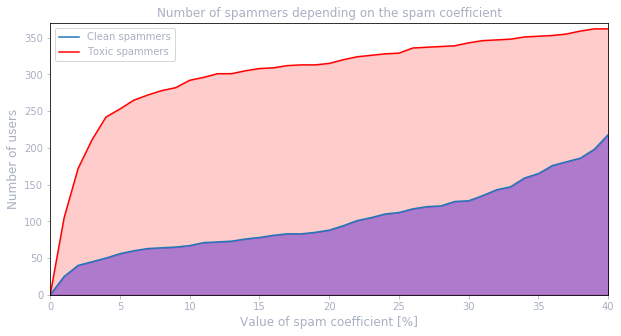

In [19]:
plt.title("Number of spammers depending on the spam coefficient", fontsize=12)

plt.plot(spam_ratio_values, n_clean_spammers_values)
plt.fill_between(spam_ratio_values, n_clean_spammers_values, 0, color='blue', alpha=0.4)  
plt.plot(spam_ratio_values, n_toxic_spammers_values, 'r')
plt.fill_between(spam_ratio_values, n_toxic_spammers_values, 0, color='red', alpha=0.2) 

plt.legend(['Clean spammers', 'Toxic spammers'])
plt.ylabel('Number of users', fontsize=12)
plt.xlabel('Value of spam coefficient [%]', fontsize=12)
plt.xlim(0, 40)
plt.ylim(0, 370)
plt.show()

In [20]:
spam_min_index = min(n_clean_spammers, n_toxic_spammers) - 1
print("Sample clean spam:\n\n>", clean_spammers.iloc[randint(0, spam_min_index)].comment_text)
print("\n --- \n\nSample toxic spam:\n\n>", toxic_spammers.iloc[randint(0, spam_min_index)].comment_text)

Sample clean spam:

> LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LO

##### Create synthetic training data using a Markov chain generator

In [21]:
classes_names = train.columns.values[2:]
labels_train = train[classes_names].values
comments_train = train["comment_text"]

In [22]:
# One-hot vectors for each class
targets = np.array(np.arange(6)).reshape(-1)
one_hot_targets = np.eye(len(classes_names))[targets]
one_hot_targets_assigned = {}
for label in range(len(classes_names)):
    one_hot_targets_assigned[classes_names[label]] = one_hot_targets[label]

In [23]:
# Evaluate only negative classes
max_n_samples = max(summed_labels_extended_train[0:6])
acceptable_imbalance_factor = .5
n_samples_deficiency_factor = max_n_samples * acceptable_imbalance_factor

def get_deficient_classes(labels):
    deficient_classes = []
    for label in labels:
        n_samples_in_class = train[train[label] == True].shape[0]
        if (n_samples_in_class < n_samples_deficiency_factor): 
            deficient_classes.append(label)
    print('Qualified classes: %s' % deficient_classes)
    print('---')
    return deficient_classes

def get_params_for_markov_generator(labels):
    markov_params = {}
    for label in labels:
        label_params = {}
        imbalance_ratios_class_names
        label_comments = train[train[label] == True]['comment_text'].reset_index(drop=True)
        label_comments_bundle = label_comments.tolist()
        label_median_n_chars = int(label_comments.str.len().median())
        label_params['median_n_chars'] = label_median_n_chars
        print('Training Markov chain for class \'%s\'...' % label)
        label_params['markov_chain'] = mk.Text(label_comments_bundle)
        markov_params[label] = label_params
    print('---')
    return markov_params

def generate_synthetic_comments(params_for_markov_generator):
    synthetic_comments = {}
    for label in params_for_markov_generator:
        label_synthetic_comments = []
        label_model = params_for_markov_generator[label]['markov_chain']
        label_comment_length = params_for_markov_generator[label]['median_n_chars']
        label_n_comments = (max_n_samples * acceptable_imbalance_factor) - summed_labels_extended_train[label]
        print('Genereting %d synthetic comments of max. lenght %d for class \'%s\'...' % 
              (label_n_comments, label_comment_length, label))
        for i in range(int(label_n_comments)):
            label_synthetic_comments.append(label_model.make_short_sentence(label_comment_length))
        synthetic_comments[label] = label_synthetic_comments
    return synthetic_comments

def add_synthetic_comments_to_train(synthetic_comments):
    comments_train_list = comments_train.tolist()
    added_comments_sum = 0
    for label in synthetic_comments:
        comments_train_list = comments_train_list + synthetic_comments[label]
        added_comments_sum = added_comments_sum + len(synthetic_comments[label])
    # Transform back to Pandas object
    extended_comments_train = pd.Series(comments_train_list, name='comment_text')
    print('Data consistent after merging :', 
          validate_original_and_extended_sets(comments_train, extended_comments_train, added_comments_sum))
    return extended_comments_train
    
def validate_original_and_extended_sets(original_set, extended_set, added_comments_sum):
    old_n_samples = original_set.shape[0]
    shape_validation = old_n_samples + added_comments_sum == extended_set.shape[0]
    type_validation = type(original_set) == type(extended_set)
    random_index = randint(0, old_n_samples)
    random_comment_new_set = extended_set[random_index]
    random_comment_old_set = original_set[random_index]
    content_validation = random_comment_new_set == random_comment_old_set
    return shape_validation and type_validation and content_validation
    
def add_labels_of_synthetic_comments_to_train(synthetic_comments):
    list_label_matrices = []
    added_vectors_sum = 0
    # Collect all matrices into list
    for label in synthetic_comments:
        label_matrix = create_multipled_matrix(label)
        list_label_matrices.append(label_matrix)
        added_vectors_sum = added_vectors_sum + len(label_matrix)
    stacked_matrix_labels = concatenate_matrices(list_label_matrices)
    extended_labels_train = np.append(labels_train, stacked_matrix_labels, axis=0)
    print('Labels consistent after merging :', 
          validate_original_and_extended_labels(labels_train, extended_labels_train, added_vectors_sum))
    return extended_labels_train
        
def create_multipled_matrix(label):
    label_matrix = []
    for comment in range(len(synthetic_comments[label])):
        label_matrix.append(one_hot_targets_assigned[label])
    label_n_synthetic_comments = len(synthetic_comments[label])
    label_n_new_labels = len(label_matrix)
    assert label_n_synthetic_comments == label_n_new_labels
    return label_matrix

def concatenate_matrices(list_label_matrices):
    assert len(list_label_matrices) > 0
    stacked_matrix_labels = list_label_matrices[0]
    if (len(list_label_matrices) > 1):
        for i in np.arange(1, (len(list_label_matrices))):
            stacked_matrix_labels = np.concatenate((stacked_matrix_labels, list_label_matrices[i]))
    return stacked_matrix_labels
    
def validate_original_and_extended_labels(original_labels, extended_labels, added_vectors_sum):
    old_n_vectors = len(original_labels)
    length_validation = old_n_vectors + added_vectors_sum == len(extended_labels)
    random_index = randint(0, old_n_vectors)
    random_vector_new_labels = extended_labels[random_index]
    random_vector_old_labels = original_labels[random_index]
    content_validation = random_vector_new_labels == random_vector_old_labels
    if False in content_validation:
        content_validation_final = False
    else:
        content_validation_final = True
    return length_validation and content_validation_final

In [24]:
deficient_classes = get_deficient_classes(classes_names)
params_for_markov_generator = get_params_for_markov_generator(deficient_classes)
synthetic_comments = generate_synthetic_comments(params_for_markov_generator)

Qualified classes: ['severe_toxic', 'threat', 'identity_hate']
---
Training Markov chain for class 'severe_toxic'...
Training Markov chain for class 'threat'...
Training Markov chain for class 'identity_hate'...
---
Genereting 6052 synthetic comments of max. lenght 94 for class 'severe_toxic'...
Genereting 7169 synthetic comments of max. lenght 121 for class 'threat'...
Genereting 6242 synthetic comments of max. lenght 114 for class 'identity_hate'...


In [33]:
for label in deficient_classes:
    print('Sample synthetic comment of \'%s\' class\n' % label)
    print('> %s \n' % synthetic_comments[label][randint(0, len(synthetic_comments[label]))])

Sample synthetic comment of 'severe_toxic' class

> I really hope you die motherfucker 

Sample synthetic comment of 'threat' class

> I am going to hunt you down and murder you violently, you disgusting transsexual You are gay. 

Sample synthetic comment of 'identity_hate' class

> fucking virgin fuck go fuck ur hole family 



In [26]:
extended_comments_train = add_synthetic_comments_to_train(synthetic_comments)
extended_labels_train = add_labels_of_synthetic_comments_to_train(synthetic_comments)

Data consistent after merging : True
Labels consistent after merging : True


In [27]:
# Check for nulls in generated comments
null_indexes = extended_comments_train[extended_comments_train.isnull()].index.tolist()
print('Found %d invalid comment(s)' % len(null_indexes))
if len(null_indexes) > 0:
    for index in null_indexes:
        extended_comments_train = extended_comments_train.drop(index).reset_index(drop=True)
    extended_labels_train = np.delete(extended_labels_train, null_indexes, axis=0)
    print('Incorrect data on following indexes was deleted: \n%s' % null_indexes)
print('---')
    
# final validation    
overall_consistency = extended_comments_train.shape[0] == len(extended_labels_train)
print('Labels and comments consistent: %s ' % overall_consistency)

Found 0 invalid comment(s)
---
Labels and comments consistent: True 


##### Plot differences in state of training dataset after oversampling

In [28]:
oversampled_summed_label = pd.DataFrame(extended_labels_train).sum()
oversampled_summed_label.index = classes_names
original_summed_labels = summed_labels_extended_train[0:6]

data = pd.DataFrame(pd.concat([oversampled_summed_label, original_summed_labels], axis=1).reset_index())

data_for_barplot = pd.melt(data, id_vars='index', var_name='State of dataset', value_name='Number of samples')
data_for_barplot = data_for_barplot.rename(index=str, columns={'index': 'Class'})
data_for_barplot['State of dataset'] = data_for_barplot['State of dataset'].map({1: 'Before', 0: 'After'})

Text(0.5,1,'Number of samples per class before and after resampling')

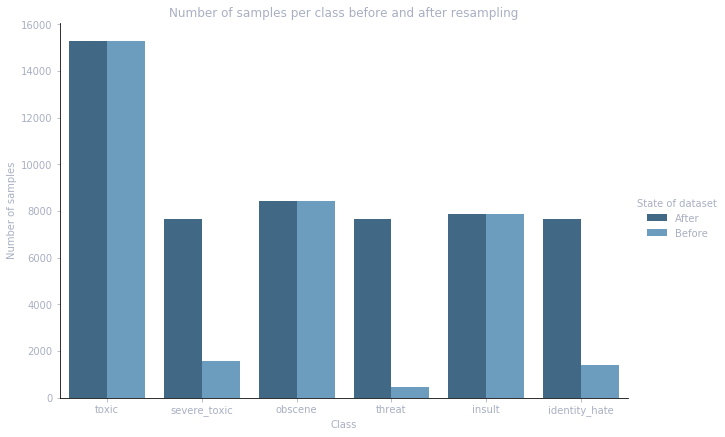

In [29]:
fg = sns.catplot(x='Class', 
            y='Number of samples', 
            hue='State of dataset', 
            data=data_for_barplot, 
            kind='bar', 
            palette="Blues_d", 
            height=6, aspect=1.5)

axes = fg.axes.flatten()
axes[0].set_title("Number of samples per class before and after resampling")

### Prepare data for model training

#####  Custom Tokenizer

In [30]:
num_words = 25000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list(comments_train))
print('Found %d unique words.' % len(tokenizer.word_index))

Found 210337 unique words.


In [31]:
# Check first 20 unique words with the highest occurance from our dictonary
dict(list(tokenizer.word_index.items())[0:20])

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'you': 6,
 'i': 7,
 'is': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'this': 13,
 'not': 14,
 'on': 15,
 'be': 16,
 'as': 17,
 'have': 18,
 'are': 19,
 'your': 20}

##### Pre-trained GloVe model

#####  Comments tokenizing

In [152]:
comments_test = test['comment_text']

tokenized_sequences_train = tokenizer.texts_to_sequences(extended_comments_train)
tokenized_sequences_test = tokenizer.texts_to_sequences(comments_test)

AttributeError: 'NoneType' object has no attribute 'lower'

In [ ]:
# Analysis of lengths of comments (maxlen param)
n_words_comments = [len(comment) for comment in tokenized_sequences_train]
plt.hist(n_words_comments, bins=np.arange(0,300,5))
plt.show()

##### Vector padding

In [ ]:
maxlen = 180
fixed_sequences_train = pad_sequences(tokenized_sequences_train, maxlen=maxlen)
fixed_sequences_test = pad_sequences(tokenized_sequences_test, maxlen=maxlen)

print('Before padding: (', len(tokenized_sequences_train[6]) ,'elements )\n', tokenized_sequences_train[6])
print('\nAfter padding: (', len(fixed_sequences_train[6]) ,'elements )\n', fixed_sequences_train[6])

##### <font color="red">!</font> Oversampling

### Building the model

In [ ]:
# Params for model training
batch_size = 64
epochs = 2
n_classes = len(classes_names)

##### Tuning params with Grid Search

In [ ]:
def create_model(lstm_units = 100, 
                 lstm_recurrent_dropout = 0.2, 
                 lstm_return_sequences = True, 
                 dropout_rate = 0.2, 
                 relu_dense_units = 50, 
                 optimizer = 'adam'):
    model = Sequential()
    model.add(Embedding(input_dim=num_words, output_dim=embedding_output_dim))
    ''''model.add(Embedding(input_dim=resultant_num_words,
                        output_dim=embedding_output_dim,
                        embeddings_initializer=Constant(embedding_matrix),
                        input_length=maxlen,
                        trainable=False))'''
    model.add(LSTM(units=lstm_units, 
                   return_sequences=lstm_return_sequences, 
                   recurrent_dropout=lstm_recurrent_dropout))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=relu_dense_units, activation='relu'))
    model.add(Dense(n_classes, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [ ]:
param_grid = {
    'lstm_units': [100],
    'dropout_rate': [0.2],
    'optimizer': ['adam'],
    'relu_dense_units': [50],
    'lstm_recurrent_dropout': [0.2],
    'lstm_return_sequences': [True]
}

In [ ]:
# Define callbacks
name_checkpoint_file = 'checkpoint.weights.hdf5'
checkpoint = ModelCheckpoint(filepath=f'{MODEL_PATH}{name_checkpoint_file}',
                             monitor='val_loss',
                             mode='min',
                             verbose=2,
                             save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode="min", patience=0)

callbacks_list = [checkpoint, early_stopping]

In [ ]:
model = KerasClassifier(build_fn=create_model, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=0.1,
                        verbose=2)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)

### Model training

In [ ]:
X_train = fixed_sequences_train
y_train = extended_labels_train

grid_result = grid.fit(X_train, 
                       y_train, 
                       #class_weight=imbalance_ratios_class_nums, 
                       callbacks=callbacks_list, 
                       verbose=2)

In [95]:
print("Best params:\n %s (score: %f)" % (grid_result.best_params_, grid_result.best_score_))

Best params:
 {'dropout_rate': 0.2, 'lstm_recurrent_dropout': 0.2, 'lstm_return_sequences': True, 'lstm_units': 100, 'optimizer': 'adam', 'relu_dense_units': 50} (score: 0.038104)


In [96]:
params = grid_result.cv_results_['params']
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
print('All results:')
for param, mean, std in zip(params, means, stds):
    print('\nSet of params:\n %r\n Mean: (%f); Standard deviation: %f' % (param, mean, std))

All results:

Set of params:
 {'dropout_rate': 0.2, 'lstm_recurrent_dropout': 0.2, 'lstm_return_sequences': True, 'lstm_units': 100, 'optimizer': 'adam', 'relu_dense_units': 50}
 Mean: (0.038104); Standard deviation: 0.001951


##### Save and load model

In [97]:
name_model_file = 'overscaled-weights-minor-classes-custom-emb.model.json'
name_weights_file = 'overscaled-weights-minor-classes-custom-emb.weights.h5'

def save_model_to_JSON(model):
    model_json = model.to_json()
    with open(f'{MODEL_PATH}{name_model_file}', 'w') as json_file:
        json_file.write(model_json)
    print('Saved model to disk')
        
def save_weights_to_HDF5(model):
    model.save_weights(f'{MODEL_PATH}{name_weights_file}')
    print('Saved weights to disk')

def load_json_wih_weights_to_model(name_model_file, name_weights_file):
    json_file = open(f'{MODEL_PATH}{name_model_file}', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(f'{MODEL_PATH}{name_weights_file}')
    print('Loaded model with weights from disk')
    return loaded_model

In [69]:
# Save model
best_model = grid_result.best_estimator_.model
save_model_to_JSON(best_model)
save_weights_to_HDF5(best_model)

Saved model to disk
Saved weights to disk


In [98]:
# Load model
loaded_model = load_json_wih_weights_to_model(name_model_file, name_weights_file)
loaded_model.summary()

Loaded model with weights from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         2500000   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 100)         80400     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total params: 2,585,756
Trainable params: 2,585,756
Non-trainable params: 0
______________________________

##### Predicting on test dataset

In [71]:
def drop_entries_with_invalid_labels(test, test_labels):
    indexes_invalid_labels = test_labels.index[test_labels['toxic'] == -1].tolist()
    valid_test_labels = test_labels.drop(test_labels.index[indexes_invalid_labels])
    valid_test = np.delete(test, indexes_invalid_labels, axis=0)
    assert (valid_test_labels.shape[0] == len(valid_test))
    return valid_test, valid_test_labels

In [72]:
test_labels_without_ids = test_labels.iloc[:,1:]
X_test, y_test_df = drop_entries_with_invalid_labels(fixed_sequences_test, test_labels_without_ids)

y_pred_float = loaded_model.predict([X_test], batch_size=1024)
y_pred = (y_pred_float > .5)
y_test = y_test_df.values

##### Use metrics for imbalanced learning

In [73]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_recall_fscore_support as score
from imblearn.metrics import specificity_score, sensitivity_score

precision, recall, fscore, support = score(y_test, y_pred)
kappa = cohen_kappa_score(y_test.ravel(), y_pred.ravel())
specificity = specificity_score(y_test.ravel(), y_pred.ravel())
sensitivity = sensitivity_score(y_test.ravel(), y_pred.ravel())

c:\users\andrz\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [74]:
print('Precision: \t', list(map('{:.3f}'.format, precision)))
print('Recall: \t', list(map('{:.3f}'.format, recall)))
print('F1 score: \t', list(map('{:.3f}'.format, fscore)))
print('Support: \t', support)
print('\n --- \n')
print('Kappa score: \t{:.3f}'.format(kappa))
print('Specificity: \t{:.3f}'.format(specificity))
print('Sensitivity: \t{:.3f}'.format(sensitivity))

Precision: 	 ['0.598', '0.365', '0.616', '0.000', '0.612', '0.000']
Recall: 	 ['0.742', '0.074', '0.765', '0.000', '0.573', '0.000']
F1 score: 	 ['0.662', '0.122', '0.682', '0.000', '0.591', '0.000']
Support: 	 [6090  367 3691  211 3427  712]

 --- 

Kappa score: 	0.608
Specificity: 	0.983
Sensitivity: 	0.643


Confusion matrices:


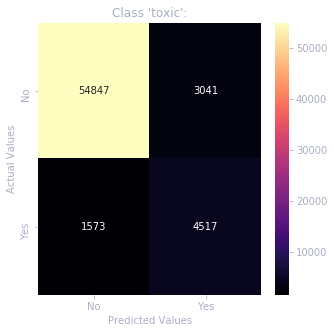

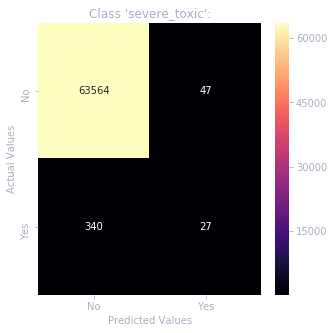

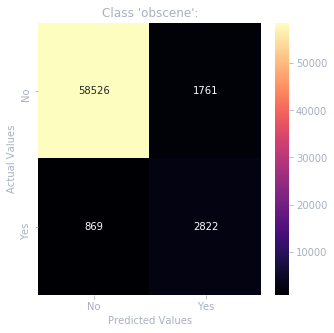

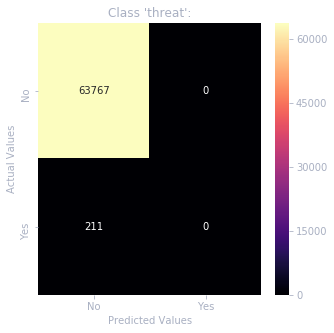

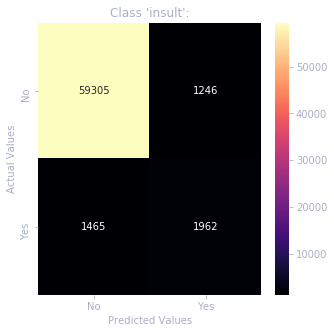

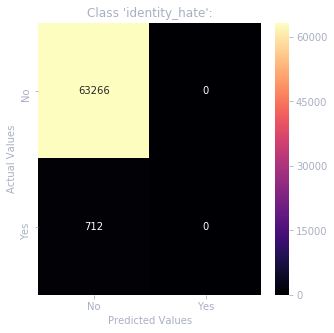

In [75]:
conf_matrices = {}
for label in range(len(classes_names)):
    y_test_label = y_test[:, label]
    y_pred_label = y_pred[:, label]
    conf_matrices[classes_names[label]] = confusion_matrix(y_pred=y_pred_label, y_true=y_test_label)
    
print("Confusion matrices:")
for label, matrix in conf_matrices.items():
    df_cm = pd.DataFrame(matrix, index = [i for i in ['No', 'Yes']], columns = [i for i in ['No', 'Yes']])
    plt.figure(figsize = (5, 5))
    ax = plt.axes()
    sns.heatmap(df_cm, annot=True, cmap='magma', fmt='g')
    ax.set_title("Class '{}':".format(label))
    ax.set_ylabel('Actual Values')    
    ax.set_xlabel('Predicted Values')
    plt.show()

##### Create submission file

##### Manual model testing

In [55]:
def prepare_comment(comment):
    tokenized_comment = tokenizer.texts_to_sequences(comment)
    return pad_sequences(tokenized_comment, maxlen=maxlen)

In [70]:
single_comment = 'Meh!'
single_prediction = loaded_model.predict([prepare_comment([single_comment])], batch_size=1024)
results = pd.DataFrame(single_prediction, columns=[classes_names])

class_with_highest_prob = results.idxmax(axis=1).get(0)[0]
highest_prob = results.max(axis=1).get(0)

happy_face = '\ (•◡•) /'
sad_face = '¯\_(ツ)_/¯'

if (highest_prob > .5):
    print('\nDeteced class: ', class_with_highest_prob, '\nScore: ', highest_prob * 100, ' %\n\n', sad_face)
else:
    print('\nNo toxicity detected!\n\n', happy_face)
print('\nAll results:\n', results)


No toxicity detected!

 \ (•◡•) /

All results:
       toxic severe_toxic   obscene    threat   insult identity_hate
0  0.011582     0.000065  0.002869  0.001177  0.00186      0.001015


##### <font color="#7affa0">TODO:</font>
- <font color="green">✔</font> add plot of spammers classification based on variable spam_ratio
- ⌛ try to use new features from EDA during model fitting (e. g. spam)
- ⌛ execute SearchGrid of model's params
    - ⌛ try diffrent values of non-model params num_words (Tokenizer), maxlen (padding)
- <font color="green">✔</font> update Tensorflow to GPU version
- try diffrent architectures:
    - ⌛ Pooling (Max -> Average)
    - <font color="green">✔</font> Early Stopping and Checkpoints (callbacks)
    - <font color="green">✔</font> Pretrained Embedding (Glove)

##### <font color="#a07aff">Konsultacje:</font>
- Klasyfikacja dwupoziomowa: binarna (clean/toxic data) + wieloetykietowa (tylko toxic data)
- <font color="green">✔</font> Dataset jest niezrównoważony (10/90); klasyfikacja niezrównoważona
- Oversampling
- <font color="green">✔</font> Sprawdzić macierz pomyłek
- <font color="green">✔</font> Klasyfikacja hierarchiczna (np. severe toxic zawsze jest toxic)
- <b>Zrobić przegląd literatury</b>